In [ ]:
#| default_exp utils
%load_ext autoreload
%autoreload 2

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export

import numpy as np, pandas as pd
import torch
import random

def group_extract(df, group, index='samples', groupby='samples'):
    return df.groupby(groupby).get_group(group).set_index(index).values

def sample(data, group, size=(100, ), replace=False, to_torch=False, use_cuda=False):
    sub = group_extract(data, group)
    idx = np.arange(sub.shape[0])
    sampled = sub[np.random.choice(idx, size=size, replace=replace)]
    if to_torch:
        sampled = torch.Tensor(sampled).float()
        if use_cuda:
            sampled = sampled.cuda()
    return sampled

def to_np(data):
    return data.detach().cpu().numpy()

def generate_steps(groups):
    return list(zip(groups[:-1], groups[1:]))
    
def set_seeds(seed:int):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

def config_hold_out(df:pd.DataFrame, hold_out:str='random', hold_one_out:bool=False):
    DF = None
    if not hold_one_out: # NOTE: we use all data
        # NOTE: if hold one out is True and hold_out not 'random', 
        # we train the DAE without this sample
        DF = df
        groups = sorted(df.samples.unique())
    elif hold_one_out is True and hold_out in groups:
        # create tmp df without all samples
        df_ho = df.drop(df[df['samples']==hold_out].index, inplace=False)
        DF = df_ho
        groups = sorted(df_ho.samples.unique())
    else:
        raise ValueError(f'group={hold_out} not in known groups {groups}')
    return DF, groups

from MIOFlow.losses import MMD_loss, OT_loss, density_specified_OT_loss
def config_criterion(criterion_name:str='ot', use_cuda:bool=False, **kwargs):
    _valid_criterion_names = 'ot mmd'.split()
    if criterion_name == 'mmd':
        criterion = MMD_loss()
    elif criterion_name == 'ot':
        criterion = OT_loss(use_cuda=use_cuda)
    elif criterion_name == 'density_specified_ot':
        criterion = density_specified_OT_loss(**kwargs)
    else:
        raise NotImplementedError(
            f'{criterion_name} not implemented.\n'
            f'Please use one of {_valid_criterion_names}'
        )
    return criterion

In [ ]:
#| export
def get_groups_from_df(df, samples_key='samples', samples=None):
    '''
    Arguments
    ---------
        df (pd.DataFrame): DataFrame of shape (n_cells, n_genes), where the ordering of 
            the columns `n_genes` corresponds to the columns of `principle_components`.
            It is assumed that the index of `df` are the cell types (but this need not be the case. 
            See `cell_types`). If there are additional columns (e.g. `samples_key`, `cell_type_key`)
            should be after the gene columns.

        samples_key (str): The name of the column in the `df` that corresponds to the time
            samples. Defaults to `"samples"`. If `df[samples_key]` throws a `KeyError` 
            either because the `df` doesnt have this column in it or typo, will resort to
            `samples` to determine this.
                        
        samples (np.ndarray | list): List of timepoints where each value corresponds to the 
            timepoint of the same row in `df`. Defaults to `None`.
    
    Returns
    -------
        groups (np.ndarray): List of time groups in order (e.g. `[0, 1, 2, 3, 4, 5, 6, 7]`).
    '''
    # Figure out groups from provided samples    
    try:
        groups = sorted(df[samples_key].unique())  
    except KeyError:
        if samples is not None:
            groups = sorted(np.unique(samples))  
        else:
            raise ValueError(
                f'DataFrame df has no key {samples_key} and backup list of samples'
                f' samples is None.'
            )
    return groups

def get_cell_types_from_df(df, cell_type_key=None, cell_types=None):
    '''
    Arguments
    ---------
        df (pd.DataFrame): DataFrame of shape (n_cells, n_genes), where the ordering of 
            the columns `n_genes` corresponds to the columns of `principle_components`.
            It is assumed that the index of `df` are the cell types (but this need not be the case. 
            See `cell_types`). If there are additional columns (e.g. `samples_key`, `cell_type_key`)
            should be after the gene columns.

        cell_type_key (str): The column name in the provided DataFrame `df` the corresponds to the 
            cell's cell types. Defaults to `None` which assumes the cell type is the index of the 
            `df i.e. `df.index`
        
        cell_types (np.ndarray | list): List of cell types to use from the provided DataFrame `df`.
            Defaults to `None`. If `use_cell_types = True` will attempt to figure this out from
            `cell_type_key`.
    
    Returns
    -------
        cell_types (np.ndarray): List of cell types.
    '''
    if cell_types is None:
        try:
            # No column key provided, try to use index
            if cell_type_key is None:
                cell_types = sorted(df.index.unique())
            else:
                cell_types = sorted(df[cell_type_key].unique())
        except KeyError:
            raise KeyError(
                f'DataFrame df has no key {cell_type_key} and backup list of cell types'
                ' cell_types is None'
            )
    return cell_types


def get_sample_n_from_df(
    df, n, samples_key='samples', samples=None,    
    groups=None,
    drop_index=False
):
    '''
    Arguments
    ---------
        df (pd.DataFrame): DataFrame of shape (n_cells, n_genes), where the ordering of 
            the columns `n_genes` corresponds to the columns of `principle_components`.
            It is assumed that the index of `df` are the cell types (but this need not be the case. 
            See `cell_types`). If there are additional columns (e.g. `samples_key`, `cell_type_key`)
            should be after the gene columns.

        samples_key (str): The name of the column in the `df` that corresponds to the time
            samples. Defaults to `"samples"`. If `df[samples_key]` throws a `KeyError` 
            either because the `df` doesnt have this column in it or typo, will resort to
            `samples` to determine this.
                        
        samples (np.ndarray | list): List of timepoints where each value corresponds to the 
            timepoint of the same row in `df`. Defaults to `None`.

        groups (np.ndarray): List of time groups in order (e.g. `[0, 1, 2, 3, 4, 5, 6, 7]`).
            Defaults to `None`. If `None` will attempt to figure this out from provided
            `samples_key` or `samples`.
    
        drop_index (bool): Whether or not to drop index from `df`. Defaults to `False`.

    Returns
    -------
        counts_n (pd.DataFrame): subsetted `df` where all rows correspond to `sample==n`.
    '''
    if groups is None:
        groups =  get_groups_from_df(df, samples_key, samples)
        
    try:
        counts_n = df.reset_index(drop=drop_index)[df[samples_key] == groups[n]]
    except KeyError:
        if samples is not None:
            counts_n = df.reset_index(drop=drop_index)[samples == groups[n]]
        else:
            raise ValueError(
                f'DataFrame df has no key {samples_key} and backup list of samples'
                f' samples is None.'
            )
    return counts_n

def get_times_from_groups(groups, where='start', start=0):
    '''
    Arguments
    ---------
        groups (list): the list of the numerical groups in the data, e.g. 
            `[0, 1, 2, 3, 4]`, if the data has five groups.
        
        where (str): Choices are `"start"`, and `"end"`. Defaults to `"end"`. Whether or not
            to start the trajectories at `t_0` (`"start"`) or `t_n` (`"end"`). 
    
        start (int): Defaults to `0`. Where in `generate_tjnet_trajectories` the trajectories started.
            This is used if attempting to generate outside of `t0`. Note this works relative to `where`.
            E.g. if `where="end"` and `start=0` then this is the same as `groups[-1]`.

    Returns
    -------
        times (list): The `groups` starting at `start` working from `end`.
    '''
    _valid_where = 'start end'.split()
    if where not in _valid_where:
        raise ValueError(f'{where} not known. Should be one of {_valid_where}')

    times = groups
    if where == 'end':
        times = times[::-1]
    times = times[start:]
    return times

In [12]:
#| export
import numpy as np
import torch
from scipy.stats import gaussian_kde

def kde(data, points_to_evaluate=None, bandwidth=None):
    """
    Perform kernel density estimation on n-dimensional data.
    
    Args:
        data (np.ndarray or torch.Tensor): Input data of shape (n_samples, n_dimensions)
        points_to_evaluate (np.ndarray or torch.Tensor, optional): Points at which to evaluate the KDE. 
            If None, the original data points are used.
        bandwidth (float, optional): Bandwidth for KDE. If None, Scott's rule is used.
    
    Returns:
        np.ndarray or torch.Tensor: Estimated density at each point in points_to_evaluate
    """
    is_torch = isinstance(data, torch.Tensor)
    
    if is_torch:
        original_dtype = data.dtype
        original_device = data.device
        data_np = data.cpu().numpy()
    else:
        data_np = data
    
    kde = gaussian_kde(data_np.T, bw_method=bandwidth)
    
    if points_to_evaluate is None:
        points_to_evaluate = data_np
    elif is_torch and isinstance(points_to_evaluate, torch.Tensor):
        points_to_evaluate = points_to_evaluate.cpu().numpy()
    
    result = kde(points_to_evaluate.T)
    
    if is_torch:
        result = torch.tensor(result, dtype=original_dtype, device=original_device)
    
    return result

In [13]:
# Test cases
# 1D example
data_1d = np.random.normal(0, 1, 1000).reshape(-1, 1)
density_1d = kde(data_1d)
print("1D KDE shape:", density_1d.shape)

# 2D example
data_2d = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 1000)
density_2d = kde(data_2d)
print("2D KDE shape:", density_2d.shape)

# 3D example with custom evaluation points
data_3d = np.random.multivariate_normal([0, 0, 0], np.eye(3), 1000)
eval_points = np.random.uniform(-2, 2, (500, 3))
density_3d = kde(data_3d, points_to_evaluate=eval_points)
print("3D KDE shape:", density_3d.shape)

# 4D example with custom bandwidth
data_4d = np.random.multivariate_normal(np.zeros(4), np.eye(4), 1000)
density_4d = kde(data_4d, bandwidth=0.5)
print("4D KDE shape:", density_4d.shape)

1D KDE shape: (1000,)
2D KDE shape: (1000,)
3D KDE shape: (500,)
4D KDE shape: (1000,)


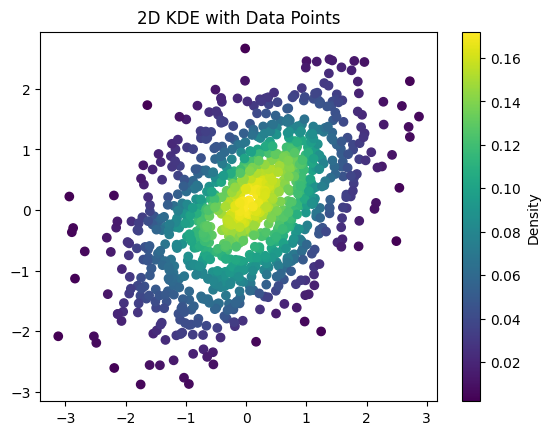

In [14]:
# 2D example
data_2d = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 1000)

# Plot 2D KDE for sanity check
import matplotlib.pyplot as plt

# Evaluate KDE on the data points
density = kde(data_2d)

fig, ax = plt.subplots()
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=density, cmap='viridis')
ax.set_title('2D KDE with Data Points')
plt.colorbar(scatter, label='Density')
plt.show()